In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import ipaddress
from sklearn.ensemble import RandomForestClassifier
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import time
from sklearn.utils import class_weight

In [2]:
import ipaddress
import pandas as pd
import numpy as np
import os

# IP 주소를 정수로 변환하는 함수
def convert_ip2int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except ValueError:
        return 0

# 데이터 로딩, 전처리 및 시계열 데이터 생성을 위한 통합 함수
def load_preprocess_and_sequence_data(file_paths, data_path='dataset/', time_window='1T', time_steps=10):
    df_list = []
    for file_name in file_paths:
        file_path = os.path.join(data_path, file_name)
        try:
            df = pd.read_csv(file_path, encoding='latin1', low_memory=False, on_bad_lines='skip')
            df.columns = df.columns.str.strip()
            df_list.append(df)
        except Exception as e:
            print(f"'{file_name}' 파일을 읽는 중 오류 발생: {e}")
            continue
    
    if not df_list:
        return np.array([]), np.array([])

    full_df = pd.concat(df_list, ignore_index=True)

    # 2. 전처리
    full_df.columns = full_df.columns.str.replace('[ /]', '_', regex=True)
    full_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    if 'Timestamp' not in full_df.columns:
        print("오류: 'Timestamp' 컬럼을 찾을 수 없습니다.")
        return np.array([]), np.array([])
        
    full_df.dropna(subset=['Timestamp'], inplace=True)
    full_df['Timestamp'] = pd.to_datetime(full_df['Timestamp'], errors='coerce')
    full_df.dropna(subset=['Timestamp'], inplace=True)

    if 'Source_IP' in full_df.columns:
        full_df['Source_IP'] = full_df['Source_IP'].astype(str).apply(convert_ip2int)
    if 'Destination_IP' in full_df.columns:
        full_df['Destination_IP'] = full_df['Destination_IP'].astype(str).apply(convert_ip2int)
    
    if 'Flow_ID' in full_df.columns:
        full_df.drop(columns=['Flow_ID'], inplace=True)

    full_df.fillna(0, inplace=True)

    full_df.set_index('Timestamp', inplace=True)
    
    if 'Label' not in full_df.columns:
        print("오류: 'Label' 컬럼을 찾을 수 없습니다.")
        return np.array([]), np.array([])
        
    full_df['Label'] = np.where(full_df['Label'] == 'BENIGN', 0, 1)

    # 3. 데이터 집계
    numeric_cols = full_df.select_dtypes(include=np.number).columns.tolist()
    agg_funcs = {col: 'mean' for col in numeric_cols if col not in ['Label']}
    agg_funcs.update({'Label': 'max'})
    
    special_aggs = {
        'Total_Fwd_Packets': 'sum', 'Total_Backward_Packets': 'sum',
        'Total_Length_of_Fwd_Packets': 'sum', 'Source_IP': 'nunique', 'Destination_IP': 'nunique'
    }
    for col, func in special_aggs.items():
        if col in full_df.columns:
            agg_funcs[col] = func

    agg_funcs = {k: v for k, v in agg_funcs.items() if k in full_df.columns}

    df_agg = full_df.resample(time_window).agg(agg_funcs)
    df_agg.fillna(0, inplace=True)

    # 4. 시퀀스 생성
    X_agg = df_agg.drop('Label', axis=1).values
    y_agg = df_agg['Label'].values

    X_seq, y_seq = [], []
    if len(X_agg) > time_steps:
        for i in range(len(X_agg) - time_steps):
            X_seq.append(X_agg[i:(i + time_steps)])
            y_seq.append(y_agg[i + time_steps - 1])
    
    return np.array(X_seq), np.array(y_seq)

In [3]:
# 하이퍼파라미터
TIME_STEPS = 10
TIME_WINDOW = '1T'

# 1. 데이터 파일 분리
data_path = 'dataset/'
all_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]
train_files = [f for f in all_files if 'Wednesday' in f]
test_files = [f for f in all_files if 'Wednesday' not in f]

print("학습용 파일:", train_files)
print("테스트용 파일:", test_files)
print("-" * 50)

# 2. 데이터 로드 및 시퀀스 생성
X_train_seq, y_train_seq = load_preprocess_and_sequence_data(train_files, data_path=data_path, time_window=TIME_WINDOW, time_steps=TIME_STEPS)
X_test_seq, y_test_seq = load_preprocess_and_sequence_data(test_files, data_path=data_path, time_window=TIME_WINDOW, time_steps=TIME_STEPS)

if X_train_seq.shape[0] == 0 or X_test_seq.shape[0] == 0:
    raise ValueError("학습 또는 테스트 데이터가 생성되지 않았습니다. 파일 및 내용을 확인하세요.")

print(f"원본 학습 데이터 형태: {X_train_seq.shape}, {y_train_seq.shape}")
print(f"원본 테스트 데이터 형태: {X_test_seq.shape}, {y_test_seq.shape}")
print("-" * 50)

# 3. 데이터 스케일링 (Min-Max Scaler)
nsamples, nsteps, nfeatures = X_train_seq.shape
X_train_2d = X_train_seq.reshape((nsamples * nsteps, nfeatures))

scaler = MinMaxScaler()
X_train_scaled_2d = scaler.fit_transform(X_train_2d)
X_train_scaled_seq = X_train_scaled_2d.reshape((nsamples, nsteps, nfeatures))

nsamples_test, nsteps_test, nfeatures_test = X_test_seq.shape
X_test_2d = X_test_seq.reshape((nsamples_test * nsteps_test, nfeatures_test))
X_test_scaled_2d = scaler.transform(X_test_2d)
X_test_scaled_seq = X_test_scaled_2d.reshape((nsamples_test, nsteps_test, nfeatures_test))

print(f"스케일링된 학습 데이터 형태: {X_train_scaled_seq.shape}")
print(f"스케일링된 테스트 데이터 형태: {X_test_scaled_seq.shape}")
print("-" * 50)

# 4. Random Forest를 위한 2D 데이터 준비
X_train_rf = X_train_scaled_seq[:, -1, :]
X_test_rf = X_test_scaled_seq[:, -1, :]

print(f"RF용 학습 데이터 형태: {X_train_rf.shape}")
print(f"RF용 테스트 데이터 형태: {X_test_rf.shape}")
print("-" * 50)

학습용 파일: ['Wednesday-workingHours.pcap_ISCX.csv']
테스트용 파일: ['Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', 'Friday-WorkingHours-Morning.pcap_ISCX.csv', 'Monday-WorkingHours.pcap_ISCX.csv', 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', 'Tuesday-WorkingHours.pcap_ISCX.csv']
--------------------------------------------------
원본 학습 데이터 형태: (710, 10, 82), (710,)
원본 테스트 데이터 형태: (131750, 10, 82), (131750,)
--------------------------------------------------
스케일링된 학습 데이터 형태: (710, 10, 82)
스케일링된 테스트 데이터 형태: (131750, 10, 82)
--------------------------------------------------
RF용 학습 데이터 형태: (710, 82)
RF용 테스트 데이터 형태: (131750, 82)
--------------------------------------------------


In [4]:
## 가중치 부여
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_seq),
    y=y_train_seq
)
class_weights_dict = dict(enumerate(class_weights))

print(f"클래스 가중치: {class_weights_dict}")

클래스 가중치: {0: 0.5689102564102564, 1: 4.127906976744186}


In [5]:
## RF
print("Random Forest 모델 학습 시작...")
RF_starttime = time.time()
RF_model = RandomForestClassifier(n_estimators=50, max_depth=20, min_samples_leaf=5, random_state=42, class_weight=class_weights_dict)
RF_model.fit(X_train_rf, y_train_seq)
RF_endtime = time.time()
RF_time = RF_endtime - RF_starttime
print("Random Forest 모델 학습 완료.")

y_pred_RF = RF_model.predict(X_test_rf)
accuracy_RF = accuracy_score(y_test_seq, y_pred_RF)
recall_RF = recall_score(y_test_seq, y_pred_RF)
f1_RF = f1_score(y_test_seq, y_pred_RF)

Random Forest 모델 학습 시작...
Random Forest 모델 학습 완료.


In [6]:
## LSTM
def create_lstm_model(input_shape, lstm_units=100, dense_units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        LSTM(lstm_units, activation='relu', input_shape=input_shape),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

print("LSTM 모델 학습 시작...")
LSTM_starttime = time.time()

input_shape = (X_train_scaled_seq.shape[1], X_train_scaled_seq.shape[2])
model_builder = lambda: create_lstm_model(input_shape=input_shape)

lstm_model = KerasClassifier(model=model_builder, epochs=25, batch_size=32, verbose=1, class_weight=class_weights_dict)
lstm_model.fit(X_train_scaled_seq, y_train_seq)
LSTM_endtime = time.time()
LSTM_time = LSTM_endtime - LSTM_starttime
print("LSTM 모델 학습 완료.")

y_pred_lstm_prob = lstm_model.predict_proba(X_test_scaled_seq)[:, 1]
y_pred_lstm = (y_pred_lstm_prob > 0.5).astype(int)
accuracy_lstm = accuracy_score(y_test_seq, y_pred_lstm)
recall_lstm = recall_score(y_test_seq, y_pred_lstm)
f1_lstm = f1_score(y_test_seq, y_pred_lstm)

LSTM 모델 학습 시작...

Epoch 1/25


23/23 [==============================] - 3s 7ms/step - loss: 0.6700 - accuracy: 0.7000
Epoch 2/25
23/23 [==============================] - 0s 8ms/step - loss: 0.5236 - accuracy: 0.7986
Epoch 3/25
23/23 [==============================] - 0s 8ms/step - loss: 0.4720 - accuracy: 0.9183
Epoch 4/25
23/23 [==============================] - 0s 8ms/step - loss: 0.3472 - accuracy: 0.8380
Epoch 5/25
23/23 [==============================] - 0s 7ms/step - loss: 0.2945 - accuracy: 0.8944
Epoch 6/25
23/23 [==============================] - 0s 7ms/step - loss: 0.2746 - accuracy: 0.9239
Epoch 7/25
23/23 [==============================] - 0s 6ms/step - loss: 0.4117 - accuracy: 0.5380
Epoch 8/25
23/23 [==============================] - 0s 7ms/step - loss: 0.3739 - accuracy: 0.7930
Epoch 9/25
23/23 [==============================] - 0s 6ms/step - loss: 0.2651 - accuracy: 0.9239
Epoch 10/25
23/23 [==============================] - 0s 7ms/step - loss: 0.2171 - accuracy: 0.9042

In [7]:
## 모델 성능 비교
print("모델 성능 비교:")

print("[Random Forest]")
print(f"- 정확도: {accuracy_RF:.4f}")
print(f"- 재현율 (Recall): {recall_RF:.4f}")
print(f"- F1-Score: {f1_RF:.4f}")
print(f"- 학습 시간: {RF_time:.4f}초")
print("성능 리포트:")
print(classification_report(y_test_seq, y_pred_RF, target_names=['BENIGN (0)', 'ATTACK (1)']))
print("-" * 50)

print("[LSTM]")
print(f"- 정확도: {accuracy_lstm:.4f}")
print(f"- 재현율 (Recall): {recall_lstm:.4f}")
print(f"- F1-Score: {f1_lstm:.4f}")
print(f"- 학습 시간: {LSTM_time:.4f}초")
print("성능 리포트:")
print(classification_report(y_test_seq, y_pred_lstm, target_names=['BENIGN (0)', 'ATTACK (1)']))
print("-" * 50)

모델 성능 비교:
[Random Forest]
- 정확도: 0.9968
- 재현율 (Recall): 0.0600
- F1-Score: 0.1092
- 학습 시간: 0.3151초
성능 리포트:
              precision    recall  f1-score   support

  BENIGN (0)       1.00      1.00      1.00    131317
  ATTACK (1)       0.60      0.06      0.11       433

    accuracy                           1.00    131750
   macro avg       0.80      0.53      0.55    131750
weighted avg       1.00      1.00      1.00    131750

--------------------------------------------------
[LSTM]
- 정확도: 0.9972
- 재현율 (Recall): 0.2102
- F1-Score: 0.3297
- 학습 시간: 8.1347초
성능 리포트:
              precision    recall  f1-score   support

  BENIGN (0)       1.00      1.00      1.00    131317
  ATTACK (1)       0.76      0.21      0.33       433

    accuracy                           1.00    131750
   macro avg       0.88      0.60      0.66    131750
weighted avg       1.00      1.00      1.00    131750

--------------------------------------------------


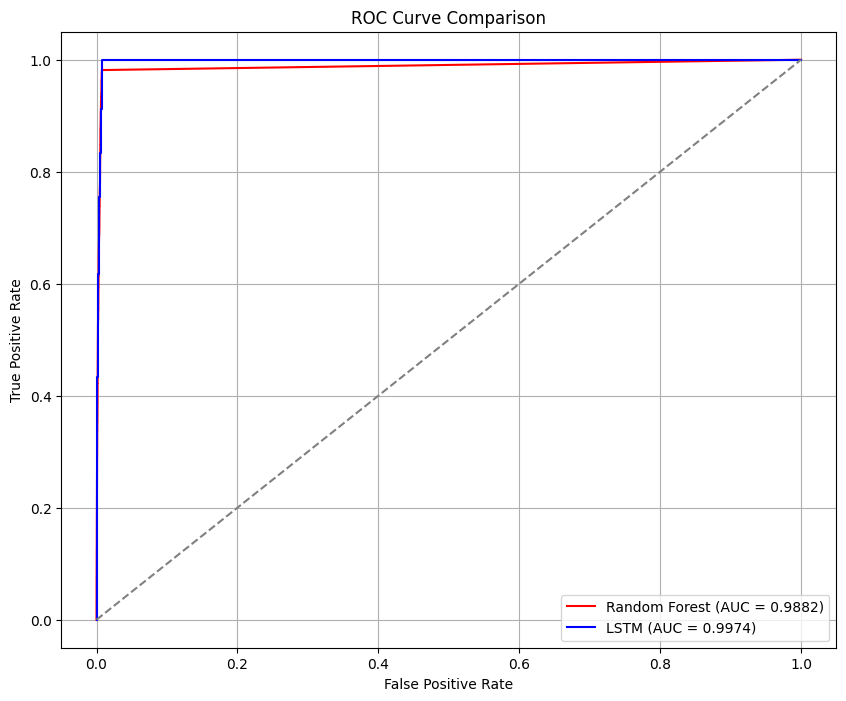

In [8]:
## ROC Curve
y_pred_prob_RF = RF_model.predict_proba(X_test_rf)[:, 1]

fpr_RF, tpr_RF, _ = roc_curve(y_test_seq, y_pred_prob_RF)
roc_auc_RF = auc(fpr_RF, tpr_RF)
plt.figure(figsize=(10, 8))
plt.plot(fpr_RF, tpr_RF, color='red', label=f'Random Forest (AUC = {roc_auc_RF:.4f})')

fpr_lstm, tpr_lstm, _ = roc_curve(y_test_seq, y_pred_lstm_prob)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.plot(fpr_lstm, tpr_lstm, color='blue', label=f'LSTM (AUC = {roc_auc_lstm:.4f})')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()

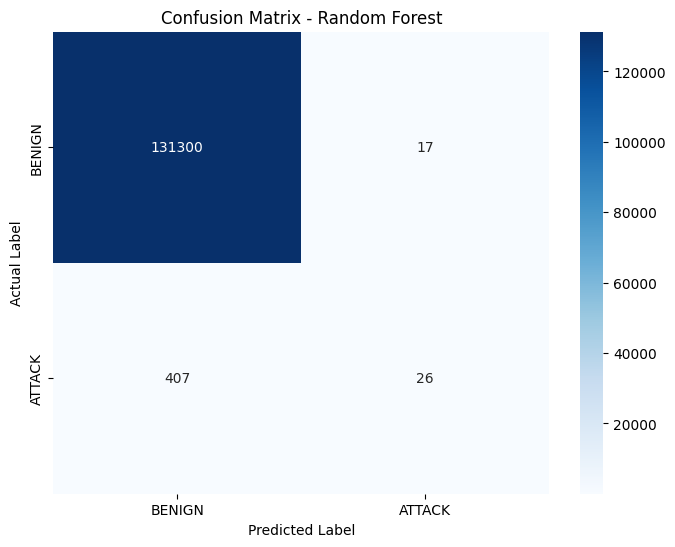

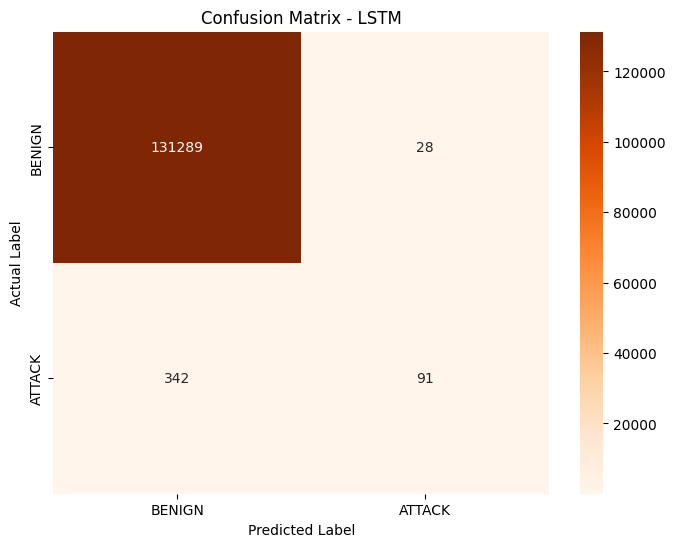

In [9]:
## Confusion Matrix

# Random Forest
cm_rf = confusion_matrix(y_test_seq, y_pred_RF)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['BENIGN', 'ATTACK'], yticklabels=['BENIGN', 'ATTACK'])
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# LSTM
cm_lstm = confusion_matrix(y_test_seq, y_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Oranges', xticklabels=['BENIGN', 'ATTACK'], yticklabels=['BENIGN', 'ATTACK'])
plt.title('Confusion Matrix - LSTM')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()